# Analyze responses
The following is an example of the analysis that can be done on individual responses that are saved when running `token_benchmark_ray.py` with the flag `--results-dir` which enables the saving of all responses.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from typing import List

## Read the input json file

In [2]:
# path to the individual responses json file
df_user = pd.read_json(f'../data/results/llmperf/COE-Meta-Llama-3-1-70B-Instruct_1000_1000_40_stream_individual_responses.json')
df_user = df_user[df_user['error_code'].isnull()]

In [3]:
# for non-batching endpoints, batch_size_used will be 1
if df_user["batch_size_used"].isnull().all():
    df_user["batch_size_used"] = 1

## Server vs client metrics
Following charts show a comparison between server-side and client-side metrics across different performance metrics

In [4]:
def plot_client_vs_server_barplots(df_user: pd.DataFrame, x_col: str, y_cols: List[str], title: str, ylabel: str) -> None:
    """
    Plots bar plots for client vs server metrics from a DataFrame.

    Args:
        df_user (pd.DataFrame): The DataFrame containing the data to plot.
        x_col (str): The column name to be used as the x-axis.
        y_cols (List[str]): A list of column names to be used as the y-axis.
        title (str): The title of the plot.
        ylabel (str): The label for the y-axis.

    Returns:
        None
    """    
    # Melt the DataFrame to have a long-form DataFrame suitable for Seaborn
    df_melted = df_user.melt(id_vars=[x_col], value_vars=y_cols, 
                             var_name='Metric', value_name='Value')

    # Create the plot
    _, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=df_melted, x=x_col, y='Value', hue='Metric', ax=ax, estimator=np.median)

    # Customize the plot
    plt.title(title)
    plt.xlabel('Batch Size Used')
    plt.ylabel(ylabel)

    # Show the plot
    plt.legend(title='Metric')
    plt.show()

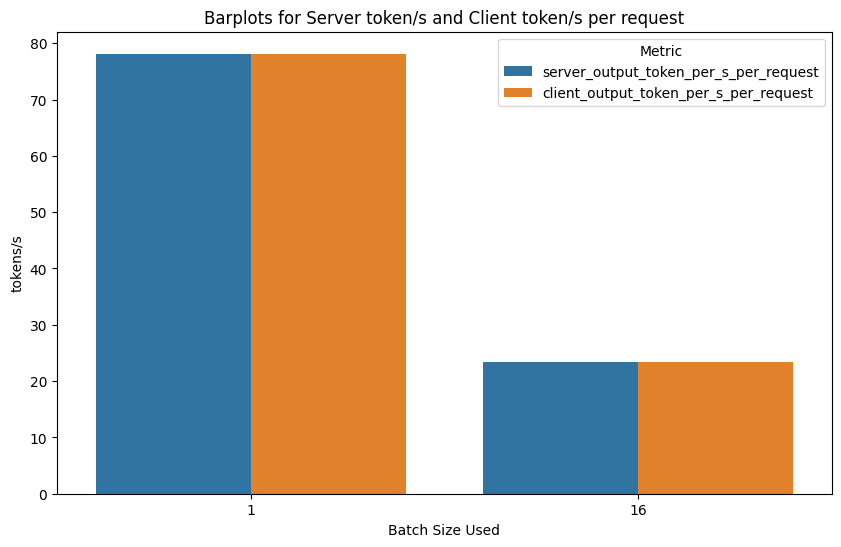

In [5]:
plot_client_vs_server_barplots(df_user, 'batch_size_used', 
                               ['server_output_token_per_s_per_request', 'client_output_token_per_s_per_request'], 
                               'Barplots for Server token/s and Client token/s per request',
                               'tokens/s')

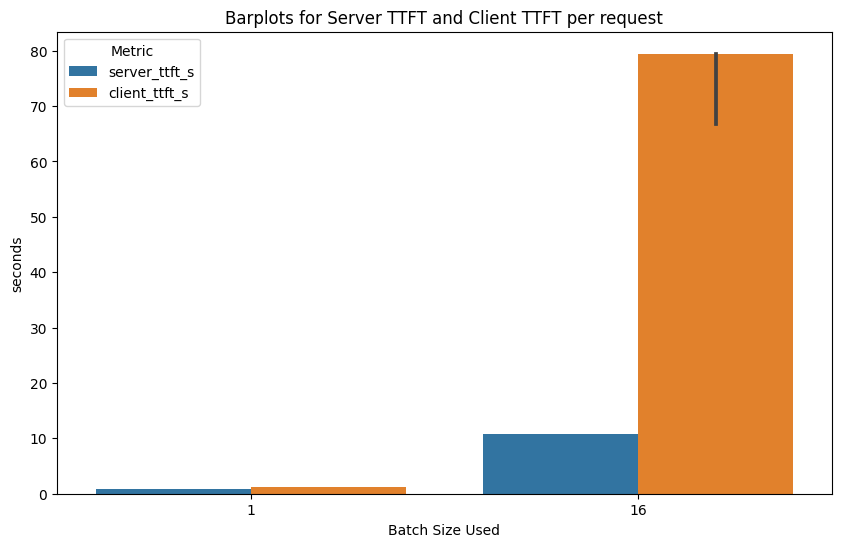

In [6]:
plot_client_vs_server_barplots(df_user, 
                               'batch_size_used', 
                               ['server_ttft_s', 'client_ttft_s'], 
                               'Barplots for Server TTFT and Client TTFT per request',
                               'seconds')

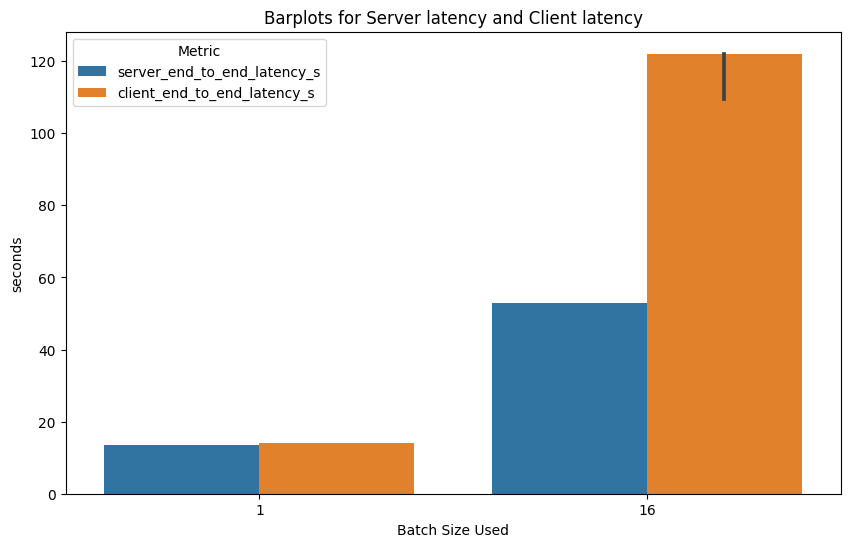

In [7]:
plot_client_vs_server_barplots(df_user, 
                               'batch_size_used', 
                               ['server_end_to_end_latency_s', 'client_end_to_end_latency_s'], 
                               'Barplots for Server latency and Client latency',
                               'seconds')

## Create a summary dataframe
Group results by batch and get sum of number of tokens, mean throughput, mean TTFT, and batch frequency. Finally, calculate the total number of output tokens per batch 

In [8]:
df_summary_thorughput = df_user.groupby('batch_size_used')['server_output_token_per_s_per_request'].mean().reset_index()
df_summary_output_tokens = df_user.groupby('batch_size_used')['server_number_output_tokens'].sum().reset_index()
df_summary_ttft = df_user.groupby('batch_size_used')['server_ttft_s'].mean().reset_index()
df_summary_count = df_user.groupby('batch_size_used').size().reset_index(name='Counts')


df_summary = pd.merge(df_summary_thorughput, df_summary_output_tokens, on='batch_size_used', how='inner')
df_summary = pd.merge(df_summary, df_summary_ttft, on='batch_size_used', how='inner')
df_summary = pd.merge(df_summary, df_summary_count, on='batch_size_used', how='inner')
df_summary['server_combined_output_tokens_per_s'] = df_summary['server_output_token_per_s_per_request']*df_summary['batch_size_used']

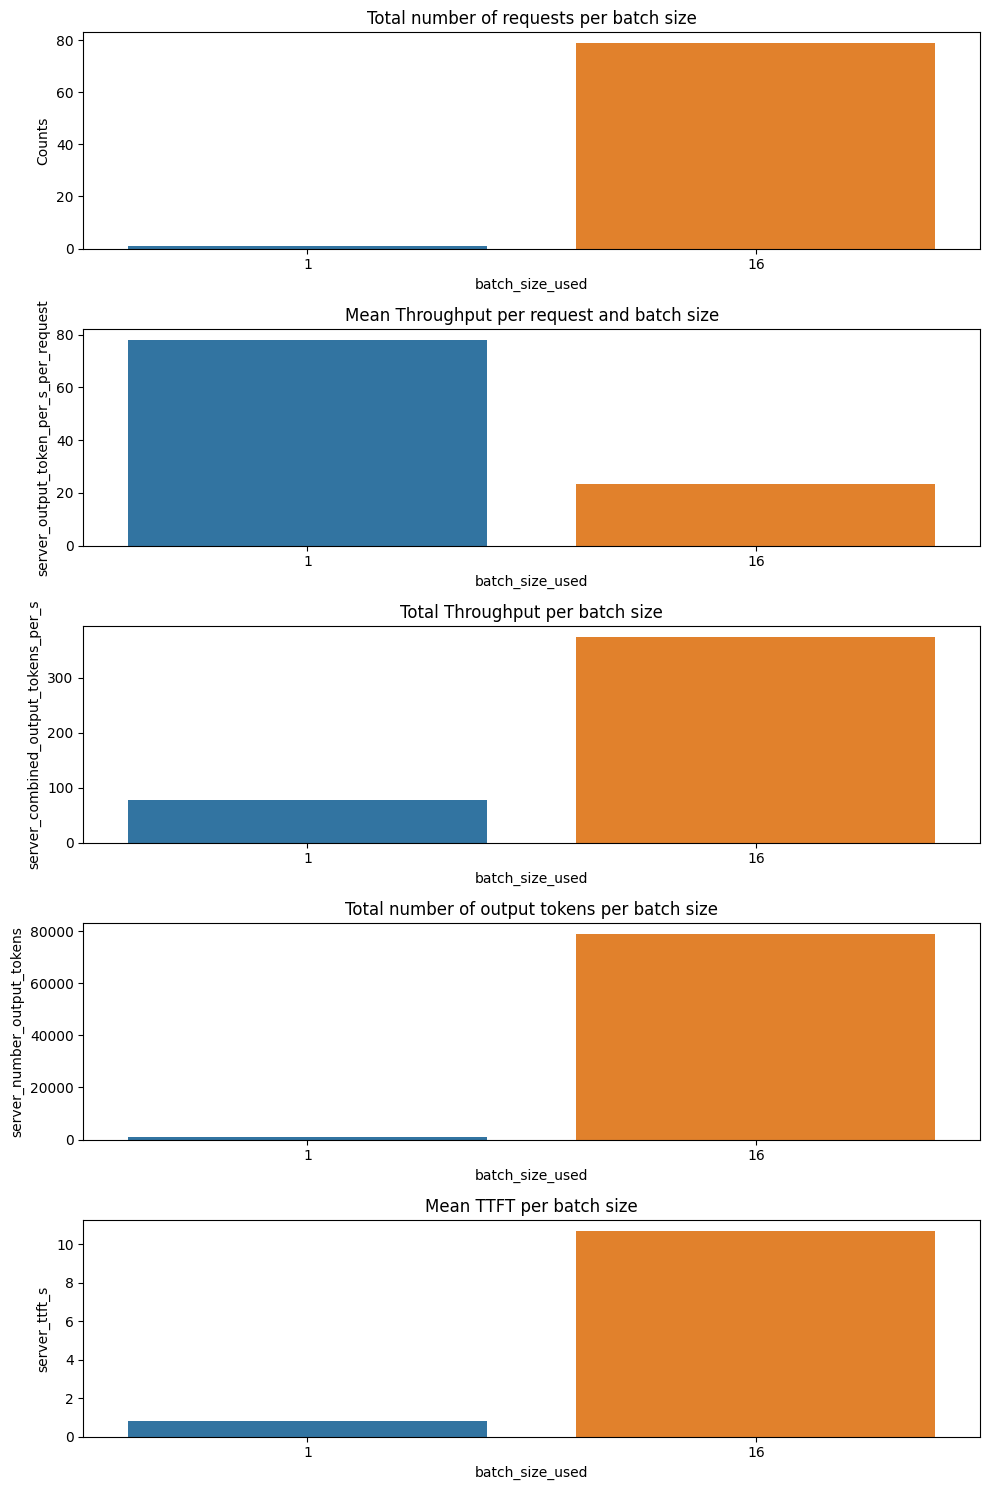

In [9]:
# show metrics 

fig, ax = plt.subplots(ncols=1,nrows=5, figsize=(10,15))

sns.barplot(df_summary, x="batch_size_used", y="Counts",ax=ax[0]).set(title="Total number of requests per batch size")
sns.barplot(df_summary, x="batch_size_used", y="server_output_token_per_s_per_request",ax=ax[1]).set(title="Mean Throughput per request and batch size")
sns.barplot(df_summary, x="batch_size_used", y="server_combined_output_tokens_per_s",ax=ax[2]).set(title="Total Throughput per batch size")
sns.barplot(df_summary, x="batch_size_used", y="server_number_output_tokens",ax=ax[3]).set(title="Total number of output tokens per batch size")
sns.barplot(df_summary, x="batch_size_used", y="server_ttft_s",ax=ax[4]).set(title="Mean TTFT per batch size")
plt.tight_layout();

## Time taken
- Approximate computation to compare the time spent waiting due to TTFT vs response generation time
- Compute the time that calls are cumulatively waiting for time-to-first-token vs time to generate tokens

In [10]:
import numpy as np
total_wait_time_ttft = (df_summary['Counts']/df_summary['batch_size_used']*df_summary['server_ttft_s']).sum()

df_summary['num_executed'] = np.ceil(df_summary['Counts'] / df_summary['batch_size_used'])
df_summary['output_tokens'] = df_summary['server_number_output_tokens']/df_summary['Counts']
total_generation_time = (df_summary['num_executed']*df_summary['output_tokens']/df_summary['server_output_token_per_s_per_request']).sum()

print(f'Total wait time due to ttft (mins) = {total_wait_time_ttft/60:,.4f}')
print(f'Total generation time due (mins) = {total_generation_time/60:,.4f}')
print(f'Total time (mins) = {(total_wait_time_ttft + total_generation_time)/60:,.4f}')

Total wait time due to ttft (mins) = 0.8954
Total generation time due (mins) = 3.7726
Total time (mins) = 4.6681


## Requests Gantt Chart
- Blue line is the total time to get back response
- Red line is the time call is waiting to be executed

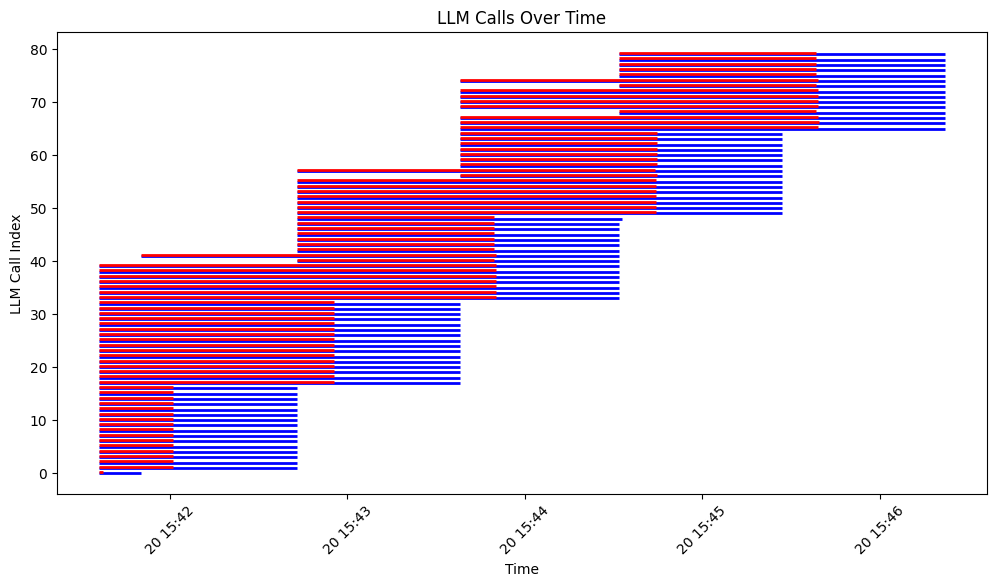

In [11]:
fig,ax = plt.subplots(figsize=(12,6))

for i, row in df_user.iterrows():
    # time that request took to finish
    ax.hlines(y=i, xmin=row["start_time"], xmax=row["end_time"], color='blue', linewidth=2)
    # ttft per request
    ax.hlines(y=i+0.25, xmin=row["start_time"], xmax=row["start_time"]+timedelta(seconds=row["client_ttft_s"]), color='red', linewidth=2)

    # if i> 100:
    #     break

# Format the x-axis to show the date and time
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("LLM Call Index")
plt.title("LLM Calls Over Time");